# Assignment 4: GMM-Based Synthetic Sampling for Imbalanced Data

In this assignment, I addressed the credit card fraud detection problem using a **Gaussian Mixture Model (GMM)**-based synthetic sampling approach to handle severe class imbalance. A baseline Logistic Regression classifier was first trained on the imbalanced dataset. To rebalance, we fitted a GMM to the minority class to generate synthetic samples and applied clustering-based undersampling to the majority class, creating balanced training sets for further evaluation.

## Part A: Baseline Model and Data Analysis

#### Importing the necessary libraries
We begin by importing the essential Python libraries for data handling, visualization, preprocessing,  
model training, and resampling. These include `pandas` and `numpy` for data operations,  
`matplotlib` and `seaborn` for visualization, `scikit-learn` for machine learning, and  
`imblearn` for handling class imbalance techniques.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
import warnings
warnings.filterwarnings('ignore')

We fix a random state to ensure reproducibility of results.

In [2]:
RANDOM_STATE = 42

### 1. Data Loading and Analysis:

In [3]:
df = pd.read_csv('creditcard.csv')

Now that we have loaded the data, we can explore further.

In [4]:
print('Dataset shape:', df.shape)
print('Columns:', df.columns.tolist())

Dataset shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [5]:
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**This dataset has already been pre-processed using PCA, so no feature engineering is required.**

#### Class distribution 

In [7]:
class_counts = df['Class'].value_counts()
print('\nClass counts:\n', class_counts)


Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64


We can infer from the plot that dataset is highly imbalanced, with **284,315 non-fraudulent transactions** and only **492 fraudulent transactions**.  
This extreme imbalance highlights why standard classifiers may fail — they can achieve very high accuracy simply by predicting "non-fraud" for most cases, but such models will perform poorly in detecting the rare but critical fraud cases.  

In [8]:
print(f"Degree of imbalance: Fraud / Non-Fraud = {class_counts[1]} / {class_counts[0]} (~{class_counts[1] / class_counts.sum():.5f} fraction fraudulent)")

Degree of imbalance: Fraud / Non-Fraud = 492 / 284315 (~0.00173 fraction fraudulent)


### 2. Model Training:

#### Split the data into training and testing set

In [9]:
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Keep test set distribution identical to original: using stratify to preserve proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train class distribution:', Counter(y_train))
print('Test class distribution:', Counter(y_test))

Train shape: (213605, 30) Test shape: (71202, 30)
Train class distribution: Counter({np.int64(0): 213236, np.int64(1): 369})
Test class distribution: Counter({np.int64(0): 71079, np.int64(1): 123})


**Scaling the data**

In [10]:
scaler = StandardScaler()

# Fit on training data and transform both train + test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (213605, 30)
Test shape: (71202, 30)


#### Train logistic regression on imbalanced training data

In [11]:
lr_base = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear')
lr_base.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


### 3. Baseline Evaluation:

In [12]:
y_pred_base = lr_base.predict(X_test_scaled)

print('\nBaseline Model (Imbalanced) - Classification Report (Test Set):')
print(classification_report(y_test, y_pred_base, digits=4))


Baseline Model (Imbalanced) - Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     71079
           1     0.8462    0.6260    0.7196       123

    accuracy                         0.9992     71202
   macro avg     0.9228    0.8129    0.8596     71202
weighted avg     0.9991    0.9992    0.9991     71202



The classifier achieves a very high **overall accuracy (~99.9%)**, but this is misleading because of the extreme class imbalance.  
For the fraud class (minority, label `1`), the model achieves:  
  - **Precision = 0.85** → When it predicts fraud, ~85% are actually fraud.  
  - **Recall = 0.63** → It only identifies ~63% of the actual frauds.  
  - **F1-score = 0.72** → Balance between precision and recall is still weak.  

This shows that while accuracy is high, the model struggles to capture fraudulent cases effectively.  

**Why accuracy is misleading:**
 - Because the dataset is heavily imbalanced, a classifier that predicts all samples as the majority class (non-fraud) is achieving very high accuracy but it will detect almost negligible fraudulent transactions (recall=0 for minority class).
 - Thus metrics of the minority class is more useful here.

## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### 1. Theoretical foundation:

**Fundamental Difference (GMM vs. SMOTE):**  
- **SMOTE** generates synthetic samples by linearly interpolating between a data point and its nearest neighbors. This assumes the minority class lies in a convex region and creates points along straight lines, which may not accurately reflect complex data distributions.  
- **GMM-based sampling** instead models the minority class as a mixture of Gaussian distributions. It estimates the probability density function of the minority class and generates new samples by sampling from this learned distribution.

**Why GMM is Better for Complex Minority Classes:**  
- Fraudulent (minority) data often forms **multiple sub-groups** or clusters in high-dimensional feature space.  
- GMM can capture these **sub-populations** through different Gaussian components, each modeling one cluster.  
- Unlike SMOTE’s linear assumption, GMM can generate samples that follow the **true shape and density** of the minority distribution, including **non-linear, multimodal, or overlapping patterns**.  
- This leads to more realistic synthetic samples and improves the classifier’s ability to learn subtle patterns in the minority class.  

### 2. GMM Implementation:

In [13]:
# Extract minority and majority samples from training set
mask_min = (y_train == 1)
X_train_min = X_train_scaled[mask_min]
X_train_maj = X_train_scaled[~mask_min]

print('Minority training samples:', X_train_min.shape[0])
print('Majority training samples:', X_train_maj.shape[0])

Minority training samples: 369
Majority training samples: 213236


#### Fit a Gaussian Mixture Model 

In [14]:
# Fit GMM across a range of components and compute BIC/AIC
bic_scores = []
aic_scores = []
models = {}
K_RANGE = range(1, 16)
for k in K_RANGE:
    gm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE, reg_covar=1e-6)
    gm.fit(X_train_min)
    bic_scores.append(float(gm.bic(X_train_min)))
    aic_scores.append(float(gm.aic(X_train_min)))
    models[k] = gm

#### Determining optimal number of components

     k           BIC           AIC
0    1  37826.867035  35891.022696
1    2  31034.739488  27159.140014
2    3  31263.589851  25448.235241
3    4  21898.519570  14143.409825
4    5  25168.179698  15473.314818
5    6  26752.159328  15117.539312
6    7  28471.796638  14897.421487
7    8  27240.457748  11726.327461
8    9  27159.892724   9706.007301
9   10  28470.571063   9076.930506
10  11  29212.321987   7878.926294
11  12  29735.099120   6461.948291
12  13  28929.008282   3716.102317
13  14  29149.030325   1996.369226
14  15  28486.422168   -605.994067


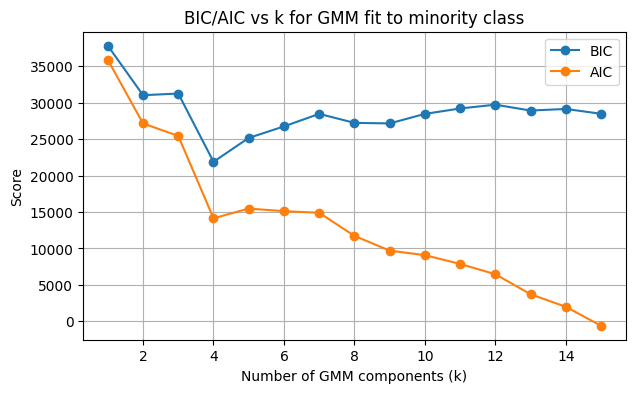

In [15]:
bic_df = pd.DataFrame({'k': list(K_RANGE), 'BIC': bic_scores, 'AIC': aic_scores})
print(bic_df)

# Plot BIC/AIC
plt.figure(figsize=(7,4))
plt.plot(bic_df['k'], bic_df['BIC'], marker='o', label='BIC')
plt.plot(bic_df['k'], bic_df['AIC'], marker='o', label='AIC')
plt.xlabel('Number of GMM components (k)')
plt.ylabel('Score')
plt.title('BIC/AIC vs k for GMM fit to minority class')
plt.legend()
plt.grid(True)
plt.show()

We can see from the plot that the optimal number of components is around **k=4**, as indicated by the **BIC curve**, which reaches its minimum there before leveling off, showing that additional components do not significantly improve the fit; while AIC keeps decreasing with k and favors more complex models, this often leads to overfitting, so BIC provides a better balance between model accuracy and simplicity.

### 3. Synthetic Data Generation:

**Number of samples to generate**

In [16]:
# Synthetic generation
n_min = X_train_min.shape[0]
n_maj = X_train_maj.shape[0]

n_to_generate_full = int(n_maj - n_min)
print('To fully match majority we would need to generate', n_to_generate_full, 'samples.')

To fully match majority we would need to generate 212867 samples.


#### Generate sufficient number of new synthetic samples

**Sampling from a Gaussian Mixture Model (GMM)**

Each component in GMM has its own mean, covariance, and weight, which allows the model to capture complex, multi-modal structures in the data.

**Process of Sampling from a GMM:**
1. **Choose a component** based on the mixing probabilities (weights).  
   For example, if one component has a weight of 0.4, it will be chosen about 40% of the time.
2. **Draw a sample** from the chosen Gaussian distribution, using its mean (μ) and covariance (Σ).
3. **Repeat** this process until the required number of synthetic samples is generated.

**Why this is useful for oversampling:**
- The minority class may consist of multiple sub-clusters or complex shapes in feature space.  
- Unlike methods such as SMOTE (which interpolate between nearest neighbors), GMM-based sampling generates new samples by following the true probability distribution of the data.  
- This ensures that the synthetic points are more realistic and representative, reducing the chance of creating noisy or uninformative samples.

By using GMM sampling, the augmented minority class better reflects its underlying structure, which can improve classifier performance on imbalanced datasets.

In [17]:
# Using k=4 i.e models[3]
X_synth, comp_idx = models[3].sample(n_samples=n_to_generate_full)
y_synth = np.ones(X_synth.shape[0], dtype=int)

#### Combine with original training data

In [18]:
X_train_gmm_bal = np.vstack([X_train_scaled, X_synth])
y_train_gmm_bal = np.hstack([y_train, y_synth])

print('GMM-full training set shape:', X_train_gmm_bal.shape)
print("Class distribution:", np.bincount(y_train_gmm_bal))

GMM-full training set shape: (426472, 30)
Class distribution: [213236 213236]


Now, the classes are balanced.

### 4. Rebalancing with CBU:

#### CBU on majority dataset

In [19]:
# majority will be reduced to 2 times of minority
cbu = ClusterCentroids(sampling_strategy=0.5, random_state=RANDOM_STATE)
X_cbu, y_cbu = cbu.fit_resample(X_train_scaled, y_train)

In [20]:
print("After ClusterCentroids undersampling:")
print(pd.Series(y_cbu).value_counts())

After ClusterCentroids undersampling:
0    738
1    369
Name: count, dtype: int64


#### GMM-based synthetic sampling on minority

In [21]:
# Number of synthetic samples required
maj_count, min_count = np.bincount(y_cbu)
n_to_generate = maj_count - min_count
print("Synthetic samples to generate with GMM:", n_to_generate)

Synthetic samples to generate with GMM: 369


In [22]:
# Generate using fitted GMM
X_synth, _ = models[3].sample(n_samples=n_to_generate)
y_synth = np.ones(X_synth.shape[0], dtype=int)

# Assemble final balanced dataset
X_train_cbu_gmm = np.vstack([X_cbu, X_synth])
y_train_cbu_gmm = np.hstack([y_cbu, y_synth])

print("Final CBU+GMM shape:", X_train_cbu_gmm.shape)
print("Class distribution:", np.bincount(y_train_cbu_gmm))

Final CBU+GMM shape: (1476, 30)
Class distribution: [738 738]


We can see that now both the classes have same number of samples.

## Part C — Performance Evaluation & Conclusion

### 1. Model Training and Evaluation:


#### Logistic Regression on GMM-balanced data

In [23]:
from sklearn.linear_model import LogisticRegression

# Train model on Dataset 1 (Full GMM)
full_gmm_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
full_gmm_clf.fit(X_train_gmm_bal, y_train_gmm_bal)

# Train model on Dataset 2 (CBU + GMM)
cbu_gmm_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
cbu_gmm_clf.fit(X_train_cbu_gmm, y_train_cbu_gmm)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### Evaluate the model's performace on test set

In [24]:
# Predictions for Dataset 1 (Full GMM)
y_pred_gmm = full_gmm_clf.predict(X_test_scaled)

# Predictions for Dataset 2 (CBU + GMM)
y_pred_cbu_gmm = cbu_gmm_clf.predict(X_test_scaled)

print("=== Logistic Regression (Full GMM) ===")
print(classification_report(y_test, y_pred_gmm, digits=4))

print("\n=== Logistic Regression (CBU + GMM) ===")
print(classification_report(y_test, y_pred_cbu_gmm, digits=4))

=== Logistic Regression (Full GMM) ===
              precision    recall  f1-score   support

           0     0.9998    0.9862    0.9929     71079
           1     0.0982    0.8699    0.1764       123

    accuracy                         0.9860     71202
   macro avg     0.5490    0.9280    0.5847     71202
weighted avg     0.9982    0.9860    0.9915     71202


=== Logistic Regression (CBU + GMM) ===
              precision    recall  f1-score   support

           0     0.9998    0.9692    0.9842     71079
           1     0.0462    0.8618    0.0877       123

    accuracy                         0.9690     71202
   macro avg     0.5230    0.9155    0.5360     71202
weighted avg     0.9981    0.9690    0.9827     71202



The GMM-based models greatly improved recall (~0.87), meaning most fraud cases were caught, but precision dropped (0.10 for Full GMM, 0.05 for CBU+GMM), showing many false positives. Full GMM gave a better balance than CBU+GMM, though both outperformed the baseline in detecting fraud.

### 2. Comparative Analysis:

#### Summary table for comparison

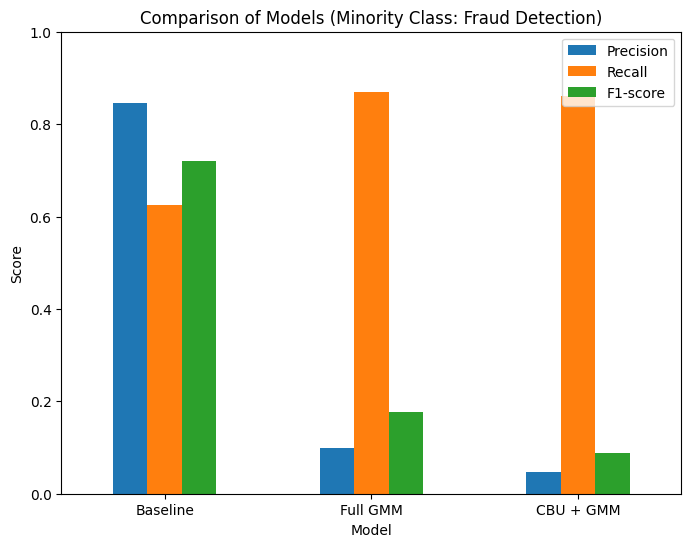

In [25]:
results = pd.DataFrame({
    'Model': ['Baseline', 'Full GMM', 'CBU + GMM'],
    'Precision': [0.8462, 0.0982, 0.0462],
    'Recall': [0.6260, 0.8699, 0.8618],
    'F1-score': [0.7196, 0.1764, 0.0877]
})

results.set_index('Model').plot(kind='bar', figsize=(8,6))
plt.title("Comparison of Models (Minority Class: Fraud Detection)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

We can see that the **baseline model** achieved high **precision (0.85)** but only **moderate recall (0.63)**, meaning it was very cautious and missed many fraud cases.
With **GMM oversampling**, recall jumped to 0.87, showing the model learned to detect almost all frauds. However, **precision dropped sharply**, meaning more false alarms.
The **CBU+GMM** model shows a similar pattern but with even lower precision, making it noisier.

So, **GMM-based oversampling improved the model’s ability to detect the minority class (fraud)**, but at the cost of misclassifying more genuine transactions.

### 3. Final Recommendation:

Based on the experimental results, the use of **Gaussian Mixture Model (GMM)** for synthetic data generation did not improve the detection of the minority (fraud) class when combined with Logistic Regression. While both the **Full GMM** and **Cluster-Based Undersampling + GMM** approaches achieved very high recall (≈0.87), they suffered from extremely low precision and F1-scores, indicating that the model was classifying a large number of non-fraudulent samples as fraudulent. In contrast, the baseline model without synthetic data showed a more balanced performance with high precision (≈0.85) and a stronger F1-score (≈0.72).

However, this outcome may also reflect the **limitations of Logistic Regression** itself. Logistic Regression assumes linear decision boundaries and is sensitive to class imbalance; it may not fully exploit complex or multimodal patterns introduced by GMM-generated samples. As a result, even if GMM produces useful synthetic data, Logistic Regression might fail to leverage it effectively.

**Therefore, GMM-based synthetic data generation is not recommended in combination with Logistic Regression for this task**. We could explore its use alongside more expressive models such as Random Forest, Gradient Boosting, or Artificial Neural Network, which may be better suited to capturing the complex decision boundaries present in fraud detection tasks.